## W266 Final Project: Project Milestone

### Classifying the Political Ideology of News Articles

#### Matt Acconciamessa and Megan Pera



In [2]:
%matplotlib inline

# Import necessary libraries
import pickle
import numpy as np
from scipy import sparse
import collections
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

### Loading, Cleaning and Exploring Data

In [3]:
# Load and save data into liberal, conservative and neutral objects
[lib, con, neutral] = pickle.load(open('ibcData.pkl', 'rb'))

In [4]:
# Data samples, by classification
print ('Liberal examples (out of ', len(lib), ' sentences): ')
for tree in lib[0:5]:
    print(tree.get_words())
    
print ('\nConservative examples (out of ', len(con), ' sentences): ')
for tree in con[0:5]:
    print (tree.get_words())
    
print ('\nNeutral examples (out of ', len(neutral), ' sentences): ')
for tree in neutral[0:5]:
    print (tree.get_words())

Liberal examples (out of  2025  sentences): 
Forcing middle-class workers to bear a greater share of the cost of government weakens their support for needed investments and stirs resentment toward those who depend on public services the most .
Because it would not be worthwhile to bring a case for $ 30.22 , the arbitration clause would , as a practical matter , deny the Concepcions any relief and , more important , eliminate a class action that might punish AT&T for its pattern of fraudulent behavior .
Indeed , Lind argues that high profits and high wages reinforce each other because workers then have the wherewithal to buy the products they are making .
In fairness , it should be noted that he devotes an entire chapter to New York Times political columnist Maureen Dowd , a liberal who makes much of the outsized rivalries , jealousies , and personalities that dominate American politics .
Psychological tactics are social control techniques that operate at the level of the mind , with th

In [5]:
# Formatting data into workable arrays
liberal = np.array(lib)
conserv = np.array(con)
neut = np.array(neutral)

# Seprating data and labels
def separate_data_and_labels(label_class):
    labels = []
    data = []
    for i in range(len(label_class)):
        for node in label_class[i]:
            if hasattr(node, 'label'):
                data.append(node.get_words())
                labels.append(node.label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

lib_data, lib_labs = separate_data_and_labels(liberal)
con_data, con_labs = separate_data_and_labels(conserv)
neut_data, neut_labs = separate_data_and_labels(neut)

In [6]:
print('Examples:')
print ('\n Liberal')
print(lib_data[0],'\n',lib_labs[0:10])
print ('\n Conservative')
print(con_data[0],'\n',con_labs[0:10])
print ('\n Neutral')
print(neut_data[0],'\n',neut_labs[0:10])

Examples:

 Liberal
Forcing middle-class workers to bear a greater share of the cost of government weakens their support for needed investments and stirs resentment toward those who depend on public services the most . 
 ['Liberal' 'Liberal' 'Liberal' 'Liberal' 'Liberal' 'Liberal' 'Liberal'
 'Liberal' 'Liberal' 'Liberal']

 Conservative
Gore is getting rich from environmentalism , not just by being paid a whopping $ 175,000 per speech but by using political pressure to force government policy in a direction that benefits his business interests . 
 ['Conservative' 'Conservative' 'Conservative' 'Conservative' 'Neutral'
 'Neutral' 'Neutral' 'Conservative' 'Liberal' 'Liberal']

 Neutral
In this country , the beneficiaries of Apple 's success are , first , the designers , who have done wonders working with Steve Jobs to produce products that are beautiful and effective . 
 ['Neutral' 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Neutral'
 'Neutral' 'Neutral' 'Neutral']


In [7]:
# Combining into one dataset
data_all = np.concatenate((neut_data, lib_data, con_data), axis=0)
labs_all = np.concatenate((neut_labs, lib_labs, con_labs), axis=0)

print (data_all.shape)
print (labs_all.shape)

(22621,)
(22621,)


In [8]:
# Randomly mixing data&labels so that they can be split into test and train
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

data_all, labs_all = shuffle_in_unison(data_all, labs_all)

# @Matt
# Should we be including a dev set as well, and reserve a test set for the very last iteration of each model?

In [9]:
# Split data into test (20%) and train (80%)
slice = int(.8*labs_all.shape[0])
data_train = data_all[:slice]
labs_train = labs_all[:slice]
data_test = data_all[slice:]
labs_test = labs_all[slice:]
print(labs_all.shape)
print(labs_test.shape)
print(labs_train.shape)

(22621,)
(4525,)
(18096,)


In [10]:
# Turning dataset into word tokens
count_vect = CountVectorizer()
data = count_vect.fit_transform(data_train).toarray()
vocab = count_vect.get_feature_names()

# Counting the number of times each word appears
np.clip(data,0,1, out = data) #make sure each word only appears once in the array
dist = np.sum(data, axis = 0) #sum the columns
counts = list(zip(vocab,dist)) #zip counts and words together

# Total vocab size and word count
print("Total word count:",np.sum(dist))
print("Vocabulary size:",len(vocab))

Total word count: 309906
Vocabulary size: 14156


In [11]:
# Printing out the 20 most popular words
counts = sorted(counts, key=lambda x: x[1], reverse=True) 
counts[0:20]

[('the', 10969),
 ('and', 7948),
 ('of', 7873),
 ('to', 7625),
 ('that', 4829),
 ('in', 4532),
 ('for', 3466),
 ('by', 2346),
 ('is', 2217),
 ('on', 2073),
 ('as', 1936),
 ('their', 1916),
 ('with', 1768),
 ('are', 1570),
 ('it', 1519),
 ('be', 1475),
 ('or', 1443),
 ('have', 1371),
 ('not', 1350),
 ('more', 1307)]

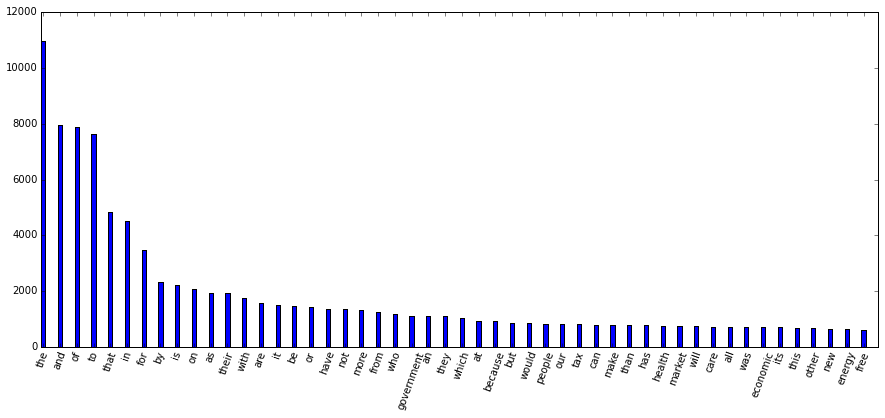

In [12]:
# Plotting top 50 results
ordered = list(zip(*counts))
x = ordered[0][:50] #counts
y = ordered[1][:50] #words

# Plotting figure
fig = plt.figure(figsize=(15.0,6.0))
indexes = np.arange(50)
width = .25
plt.bar(indexes, y, width)
plt.xticks(indexes + width * 0.5, x,rotation=70)
plt.show()

### Baseline model: Multinomial Naive Bayes


In [13]:
# This model predicts the political leanings of sentences and sub-sentences

# Training the model
vect = CountVectorizer()
train_vocab = vect.fit_transform(data_train)
test_vocab = vect.transform(data_test)

# Scoring the model
print("")
print("Multinomial Naive Bayes:")
for a in [0.0001, 0.01, .05, 0.1, 0.2, 1.0]:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(train_vocab, labs_train)
    mnbpreds = mnb.predict(test_vocab)
    print("alpha:", a, "F1:", metrics.f1_score(labs_test,mnbpreds,average='weighted'))


Multinomial Naive Bayes:
alpha: 0.0001 F1: 0.721842561344
alpha: 0.01 F1: 0.720366920343
alpha: 0.05 F1: 0.718862801137
alpha: 0.1 F1: 0.715193044252
alpha: 0.2 F1: 0.713520126151
alpha: 1.0 F1: 0.695924816142


In [14]:
# Showing examples for alpha = 0.001
mnb = MultinomialNB(alpha=0.001)
mnb.fit(train_vocab, labs_train)
mnbpreds = mnb.predict(test_vocab)
mnbpred_prob = mnb.predict_proba(test_vocab)
probs = list(zip(data_test.tolist(),mnbpreds.tolist(),mnbpred_prob.tolist()))

for i in range(0,5):
    print('Sentence:',probs[i][0])
    print('Actual Label:',labs_test[i])
    print('Predicted Label:',probs[i][1])
    print('Predicted Label Probability:', max(probs[i][2]),'\n')

Sentence: be far better spent on further stimulus
Actual Label: Liberal
Predicted Label: Liberal
Predicted Label Probability: 0.4956904453274209 

Sentence: can sell the useless cornucopia of games and gadgets for which there is no discernible `` need market '' other than the one created by capitalism 's frantic imperative to sell
Actual Label: Liberal
Predicted Label: Liberal
Predicted Label Probability: 1.0 

Sentence: that of private financial assets
Actual Label: Neutral
Predicted Label: Neutral
Predicted Label Probability: 0.45716127542061447 

Sentence: the affluent to win tax breaks
Actual Label: Liberal
Predicted Label: Liberal
Predicted Label Probability: 0.9785184625052931 

Sentence: discussed in this book
Actual Label: Neutral
Predicted Label: Neutral
Predicted Label Probability: 0.9483071147483622 



In [16]:
# Finding and printing out mistakes
errors = []
for i in range(0,len(probs)):
    if labs_test[i] == probs[i][1]:
        pass
    else:
        errors.append(i)
        
print('MNB missclassified',len(errors),'phrases','\n')

for i in errors[0:5]:
    print('Sentence:',probs[i][0])
    print('Actual Label:',labs_test[i])
    print('Predicted Label:',probs[i][1])
    print('Predicted Label Probability:', max(probs[i][2]),'\n')

MNB missclassified 1259 phrases 

Sentence: significant effects on economic mobility
Actual Label: Neutral
Predicted Label: Liberal
Predicted Label Probability: 0.6691645790771936 

Sentence: With society so polarized , the party in power can dismiss any criticism as the selfish whining of the privileged and concentrate on the serious business of diverting state resources to its own followers .
Actual Label: Conservative
Predicted Label: Liberal
Predicted Label Probability: 0.9998025236571708 

Sentence: The Earned Income Tax Credit
Actual Label: Neutral
Predicted Label: Liberal
Predicted Label Probability: 0.919463618058638 

Sentence: points on their bid
Actual Label: Neutral
Predicted Label: Liberal
Predicted Label Probability: 0.7453509691273046 

Sentence: created in Douglas and Thomas a burning anger , insecurity , and sense of class resentment , which they express by railing against institutions that , in their view , failed to recognize their worth
Actual Label: Liberal
Predict

### Sentence parser and scoring for overall article label on baseline model

In [17]:
article = dict()
article.update({'fox_00': 'president trump on tuesday signed an executive order that will make it harder for american tech companies to hire employees from foreign countries willing to work for less money than americans. trump signed the “buy american hire american” order during his visit to the snap on tools headquarters in kenosha wis. the president called the order “bold new steps” toward making good on his campaign promises to generate more jobs for out of work americans. trump called the order “a powerful signal to the world” that “finally puts america first.” “we are finally standing up for our workers and our companies” trump said. the order targets the h{DG} b visa program which allows u.s. companies to employ graduate level workers in specialty occupations like it engineering mathematics and science. among other changes the white house wants to end the h{DG} b lottery system and replace it with a merit based one   though it’s unclear exactly what criteria they would use.   “we’re going to switch away from a random lottery system in which it’s weighted toward the lowest wage workers towards a system that prioritizes higher skilled higher paid workers which would make it much more difficult to use it to replace american workers” a senior administration official said monday.   each year on april {DG} a fresh cap for h{DG} b visa applications is set by u.s. citizenship and immigration services. under the current system applications are then randomly selected in a lottery system. trump’s order also empowers federal agencies to reexamine loopholes in the government’s procurement process. specifically they would look into whether waivers in free trade agreements are leading to unfair trade by companies outside the u.s. and whether it undercuts american companies on a global playing field. on the campaign trail trump repeatedly vilified companies that looked to hire foreign workers. he vowed to end the h{DG} b program which he said allowed big business to fire americans and replace them with foreigners. currently the government’s h {DG}b visa program admits {DG} immigrants in each year to handle high tech jobs. the number of application for h{DG} b visas fell to {DG} this year from {DG} in {DG} and {DG} in {DG} according to u.s. citizenship and immigration services. trump’s order also requires applicants and their employers to demonstrate that the hb {DG} visas awards will only go to the most highly skilled workers in their fields. trump has come under fire for not practicing what he preaches. while he has pledged to support american goods and workers some of his trump branded products are made overseas or made by foreign workers. the president  also has been accused of looking the other way when his son eric trump asked to bring in {DG} workers to work at trump vineyard estates through the federal h {DG}a visa program. that program enables agricultural employers to bring in seasonal foreign workers. according to filings job orders for trump vineyard estates say the primary tasks include planting and cultivating vines adding grow tubes and pruning grape vines. during his wide ranging speech trump also promised to fix the nation’s crumbling infrastructure beef up trade deals tweak the tax code and pass a new health care bill that will replace and repeal obamacare. he also said he wanted to work with lawmakers on getting wisconsin dairy workers to get into the canadian market.'})

In [18]:
article['fox_00']

'president trump on tuesday signed an executive order that will make it harder for american tech companies to hire employees from foreign countries willing to work for less money than americans. trump signed the “buy american hire american” order during his visit to the snap on tools headquarters in kenosha wis. the president called the order “bold new steps” toward making good on his campaign promises to generate more jobs for out of work americans. trump called the order “a powerful signal to the world” that “finally puts america first.” “we are finally standing up for our workers and our companies” trump said. the order targets the h{DG} b visa program which allows u.s. companies to employ graduate level workers in specialty occupations like it engineering mathematics and science. among other changes the white house wants to end the h{DG} b lottery system and replace it with a merit based one   though it’s unclear exactly what criteria they would use.   “we’re going to switch away f

In [22]:
import re
caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    if "u.s." in text: text = text.replace("u.s.","u<prd>s<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [23]:
sentences = split_into_sentences(article['fox_00'])

In [28]:
x = len(sentences)
sen = np.asarray(sentences)
    
print ("Number of sentences in article:", x)
print ("")

vect = CountVectorizer()
train_vocab = vect.fit_transform(data_train)
test_vocab = vect.transform(sen)

# Predictions based on MNB baseline model
for a in [0.0001]:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(train_vocab, labs_train)
    mnbpreds = mnb.predict(test_vocab)

#tallying the labels
lib = 0
con = 0
neut = 0
for i in range(mnbpreds.shape[0]):
    if mnbpreds[i] == 'Liberal':
        lib += 1
    elif mnbpreds[i] == 'Conservative':
        con += 1
    else:
        neut += 1

print ('Liberal sentences:', lib)
print ('Conservative sentences:', con)
print ('Neutral sentences:', neut)

def maxlab(liberal, conservative, neutral):
    if max(liberal, conservative, neutral) == liberal:
        return 'liberal'
    elif max(liberal, conservative, neutral) == conservative:
        return 'conservative'
    else:
        return 'neutral'

#assess lean/bias
import scipy as sp

def myround(x, base=3):
    return int(base * round(float(x)/base))

z = myround(x)
distlabs = [lib,con,neut]
testerlabs = [3,20,10]
normlabs = [z/3,z/3,z/3]

#chisquare to assess normality of label ditribution
pval = sp.stats.chisquare(distlabs,normlabs)[1]
print ("")
print ("P-value of chi square:", pval)
print ("")
if pval < .05:
    print ("Article has strong %s lean" % (maxlab(lib,con,neut)))
else:
    print ("Article has moderate %s lean" % (maxlab(lib,con,neut)))


Number of sentences in article: 24

Liberal sentences: 12
Conservative sentences: 11
Neutral sentences: 1

P-value of chi square: 0.00980365503582

Article has strong liberal lean


# Megan: I'm thinking we use this basic setup, looping through a dictionary of extracted articles. The only thing that would need to change is how the predicted labels are generated (LSTM for you, CLIP for me). At the end we'll have an aggregate view of each source (# articles that are strongly conservative/moderate conservative/neutral/mod lib/strong lib) that should be interesting (either it will confirm preconceived notions or go against them)
